Deep Learning using Rectified Linear Units (ReLU)
===

*This notebook is a part of an on-going research of the same title.*

## Fashion-MNIST classification

In which we use the Fashion-MNIST dataset for evaluating our CNN-ReLU model. We first employ data preprocessing techniques such as normalization through standardization, and dimensionality reduction through principal component analysis (PCA).

We load the Fashion-MNIST dataset the same way we load MNIST.

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

/usr/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
fashion = input_data.read_data_sets('/home/darth/GitHub Projects/fashion-mnist/data/fashion', one_hot=True)

Extracting /home/darth/GitHub Projects/fashion-mnist/data/fashion/train-images-idx3-ubyte.gz
Extracting /home/darth/GitHub Projects/fashion-mnist/data/fashion/train-labels-idx1-ubyte.gz
Extracting /home/darth/GitHub Projects/fashion-mnist/data/fashion/t10k-images-idx3-ubyte.gz
Extracting /home/darth/GitHub Projects/fashion-mnist/data/fashion/t10k-labels-idx1-ubyte.gz


We load `numpy` for handling data, and `matplotlib` and `seaborn` for data visualization.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

Before employing our CNN-ReLU model on this classification problem, we attempt to reduce the dimensionality of our data. But first, we visualize the *cumulative explained variance*, to determine which features (in this case, pixels) most describe the images.

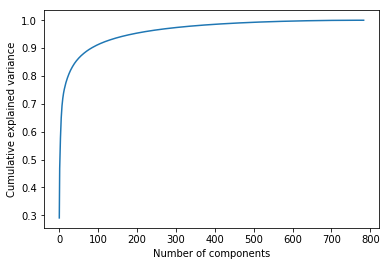

In [4]:
pca = PCA(n_components=784)
pca.fit(fashion.train.images)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

It may be noticed that the cumulative explained variance is high around 100, but still changing slightly around 200-300. Hence, we choose an arbitrary value of 256 for principal component selection.

But first, we normalize the training dataset using `StandardScaler`. Then we apply PCA for dimensionality reduction on the dataset.

In [5]:
from sklearn.preprocessing import StandardScaler

We fit the normalization function to the training dataset, so as to not get any information from the testing dataset.

In [6]:
scaler = StandardScaler().fit(fashion.train.images)

After fitting the normalization function to the training dataset alone, we transform both training and testing dataset.

In [7]:
normalized_train = scaler.transform(fashion.train.images)
normalized_test = scaler.transform(fashion.test.images)

We now select the 256 principal components.

In [8]:
pca = PCA(n_components=256)

Like in normalization, we only fitted the PCA to the training dataset.

In [9]:
reduced_train = pca.fit_transform(normalized_train)

Then we apply the fitted PCA to the testing dataset, to have them both on the same vector space.

In [10]:
reduced_test = pca.transform(normalized_test)

We list the class names in the Fashion-MNIST dataset for reports later.

In [11]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## VGG-like Convnet + ReLU + Adam + Categorical Cross-entropy

We load the VGG-like Convnet from Keras examples, with an amendment of using the ReLU function as its classification function, i.e. $max(0, \hat{y})$.

In [12]:
from models.cnn_keras import CNN

Using TensorFlow backend.


We use ReLU as activation function for each convolutional layer, softmax cross-entropy for loss function, and Adam as optimization algorithm.

In [13]:
model = CNN(activation='relu',
            classifier='relu',
            input_shape=(16, 16, 1),
            loss='categorical_crossentropy',
            num_classes=fashion.train.labels.shape[1],
            optimizer='adam',
            return_summary=True)

<log> Building graph...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)       

Train on batch size of $256$, with 10-fold cross validation, with each fold running 32 epochs.

In [14]:
model.train(batch_size=256,
            n_splits=10,
            validation_split=0.,
            verbose=0,
            train_features=np.reshape(reduced_train, (-1, 16, 16, 1)),
            train_labels=fashion.train.labels,
            epochs=32)

loss : 0.7505188028133193, acc : 0.7309229651162791
loss : 0.6294445606858231, acc : 0.7821584302325582
loss : 0.5530192871624917, acc : 0.8128293656488342
loss : 0.468552251288519, acc : 0.8391494002614356
loss : 0.4499297190579501, acc : 0.8409090909090909
loss : 0.45004472223195163, acc : 0.8499999999566512
loss : 0.4096944159454683, acc : 0.855610110994295
loss : 0.39893951664539995, acc : 0.8681098779960613
loss : 0.37760543597664203, acc : 0.8637190683266308
loss : 0.34610279169377683, acc : 0.8804367606156083
CV acc : 0.8323845070057445, CV stddev : +/- 0.043283772190833625


Evaluate the trained CNN-ReLU model.

In [15]:
report, confusion_matrix = model.evaluate(batch_size=256,
                                          test_features=np.reshape(reduced_test, (-1, 16, 16, 1)),
                                          test_labels=fashion.test.labels,
                                          class_names=class_names)

10000/10000 [==============================] - 1s 62us/step
Test loss : 0.4170548805117607
Test accuracy : 0.8584


Print the classification report which consists of the precision, recall, and f1-score for each class.

In [16]:
print(report)

             precision    recall  f1-score   support

T-shirt/top       0.80      0.85      0.82      1000
    Trouser       0.98      0.96      0.97      1000
   Pullover       0.77      0.76      0.77      1000
      Dress       0.83      0.89      0.86      1000
       Coat       0.77      0.77      0.77      1000
     Sandal       0.91      0.96      0.94      1000
      Shirt       0.66      0.57      0.62      1000
    Sneaker       0.93      0.93      0.93      1000
        Bag       0.95      0.96      0.95      1000
 Ankle boot       0.96      0.93      0.95      1000

avg / total       0.86      0.86      0.86     10000



Print the confusion matrix for the predicted labels on the Fashion-MNIST test dataset.

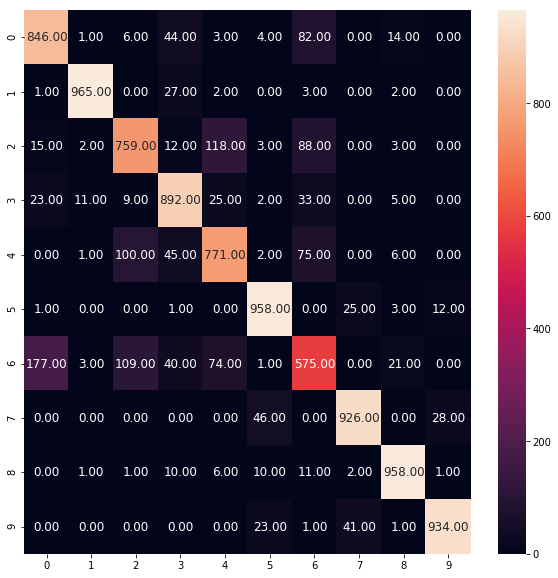

In [17]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, annot_kws={'size': 12}, fmt='.2f')

## 3-layer DNN + ReLU + Adam + Categorical Cross-entropy

We load a feed-forward neural network with ReLU activation function in its hidden layers, and ReLU as its classifier.

In [18]:
from models.dnn_keras import DNN

We use softmax cross-entropy for loss function, and Adam as optimization algorithm.

In [19]:
model = DNN(activation='relu',
            classifier='relu',
            dropout_rate=0.1,
            loss='categorical_crossentropy',
            optimizer='adam',
            num_classes=fashion.train.labels.shape[1],
            num_features=reduced_train.shape[1],
            num_neurons=[512, 512, 512],
            return_summary=True)

<log> Building graph...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)             

Train on batch size of $256$, with 10-fold cross validation, with each fold running 32 epochs.

In [20]:
model.train(batch_size=256,
            n_splits=10,
            epochs=32,
            validation_split=0.,
            verbose=0,
            train_features=np.reshape(reduced_train, (-1, 256)),
            train_labels=fashion.train.labels)

loss : 0.48950824158829315, acc : 0.8719113372093024
loss : 0.3743180247067019, acc : 0.8826308139534884
loss : 0.36243482194834137, acc : 0.892967472287843
loss : 0.3831245122021738, acc : 0.8925845145919201
loss : 0.28196667009050197, acc : 0.9252727272293785
loss : 0.20424169693751767, acc : 0.9414545453244989
loss : 0.23954720330695756, acc : 0.9443535187457297
loss : 0.19401680784527336, acc : 0.9450609422345931
loss : 0.17699867660983643, acc : 0.9659752546439525
loss : 0.11527339031443591, acc : 0.960509554226904
CV acc : 0.9222720680447611, CV stddev : +/- 0.032563339676981135


Evaluate the trained DNN-ReLU model.

In [21]:
report, confusion_matrix = model.evaluate(batch_size=256,
                                          test_features=np.reshape(reduced_test, (-1, 256)),
                                          test_labels=fashion.test.labels,
                                          class_names=class_names)

10000/10000 [==============================] - 0s 38us/step
Test loss : 0.8058574602484703
Test accuracy : 0.8906


Print the classification report which consists of the precision, recall, and f1-score for each class.

In [22]:
print(report)

             precision    recall  f1-score   support

T-shirt/top       0.83      0.84      0.83      1000
    Trouser       0.98      0.98      0.98      1000
   Pullover       0.81      0.80      0.81      1000
      Dress       0.90      0.89      0.90      1000
       Coat       0.79      0.84      0.81      1000
     Sandal       0.97      0.97      0.97      1000
      Shirt       0.73      0.69      0.71      1000
    Sneaker       0.95      0.96      0.96      1000
        Bag       0.97      0.97      0.97      1000
 Ankle boot       0.96      0.96      0.96      1000

avg / total       0.89      0.89      0.89     10000



Print the confusion matrix for the predicted labels on the Fashion-MNIST test dataset.

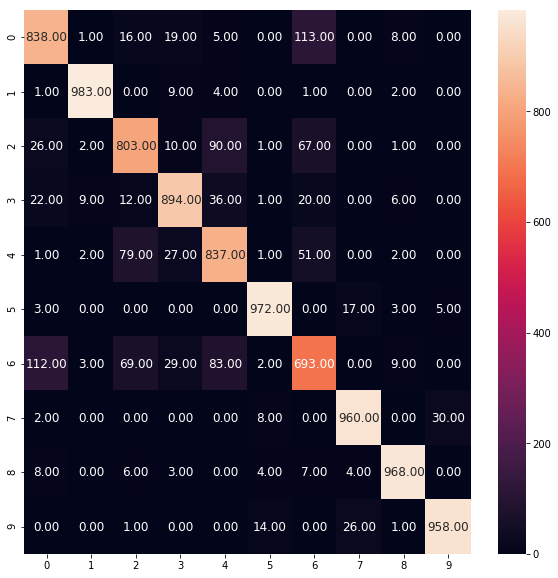

In [23]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, annot_kws={'size': 12}, fmt='.2f')

## VGG-like Convnet + Softmax + Adam + Categorical Cross-entropy

We load the VGG-like Convnet from Keras examples.

In [24]:
from models.cnn_keras import CNN

Use ReLU as activation function for each convolutional layer, softmax cross-entropy for loss function, Adam as optimization algorithm, and the conventional softmax classifier.

In [25]:
model = CNN(activation='relu',
            classifier='softmax',
            input_shape=(16, 16, 1),
            loss='categorical_crossentropy',
            num_classes=fashion.train.labels.shape[1],
            optimizer='adam',
            return_summary=True)

<log> Building graph...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 64)       

Train on batch size of $256$, with 10-fold cross validation, with each fold running 32 epochs.

In [26]:
model.train(batch_size=256,
            n_splits=10,
            validation_split=0.,
            verbose=0,
            train_features=np.reshape(reduced_train, (-1, 16, 16, 1)),
            train_labels=fashion.train.labels,
            epochs=32)

loss : 0.3691360145633997, acc : 0.8650072674418605
loss : 0.29716189075694527, acc : 0.8859011627906976
loss : 0.24752939393763843, acc : 0.9067781210248955
loss : 0.21952203101394221, acc : 0.9153035258388831
loss : 0.19975610503283414, acc : 0.925454545324499
loss : 0.16483052226630124, acc : 0.9407272725972262
loss : 0.17392755936472865, acc : 0.9312602291325696
loss : 0.15775765066843414, acc : 0.9357831543502926
loss : 0.15682461899007077, acc : 0.9414119360401815
loss : 0.14085930899883856, acc : 0.9483166513820471
CV acc : 0.9195943865923152, CV stddev : +/- 0.02545139962735262


Evaluate the trained CNN-ReLU model.

In [27]:
report, confusion_matrix = model.evaluate(batch_size=256,
                                          test_features=np.reshape(reduced_test, (-1, 16, 16, 1)),
                                          test_labels=fashion.test.labels,
                                          class_names=class_names)

10000/10000 [==============================] - 1s 61us/step
Test loss : 0.4281962988615036
Test accuracy : 0.8608


Print the classification report which consists of the precision, recall, and f1-score for each class.

In [28]:
print(report)

             precision    recall  f1-score   support

T-shirt/top       0.81      0.81      0.81      1000
    Trouser       0.99      0.96      0.98      1000
   Pullover       0.77      0.74      0.76      1000
      Dress       0.88      0.88      0.88      1000
       Coat       0.74      0.81      0.77      1000
     Sandal       0.94      0.95      0.95      1000
      Shirt       0.66      0.61      0.63      1000
    Sneaker       0.91      0.96      0.94      1000
        Bag       0.94      0.95      0.95      1000
 Ankle boot       0.96      0.93      0.95      1000

avg / total       0.86      0.86      0.86     10000



Print the confusion matrix for the predicted labels on the Fashion-MNIST test dataset.

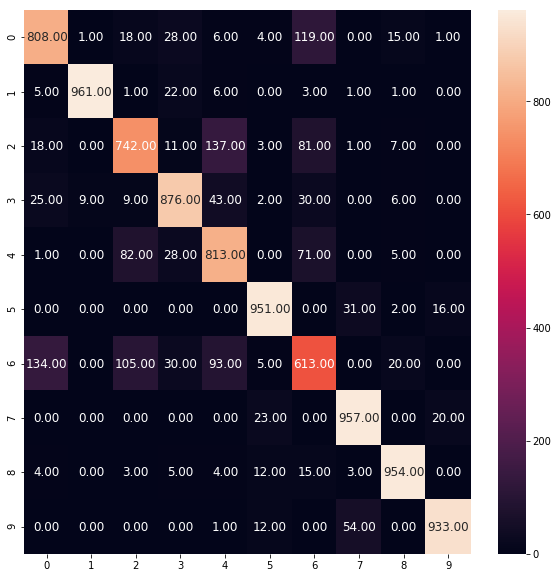

In [29]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, annot_kws={'size': 12}, fmt='.2f')

## 3-layer DNN + Softmax + Adam + Categorical Cross-entropy

We load a feed-forward neural network with ReLU activation function in its hidden layers.

In [30]:
from models.dnn_keras import DNN

We use softmax cross-entropy for loss function, and Adam as optimization algorithm, and the conventional softmax classifier.

In [31]:
model = DNN(activation='relu',
            classifier='softmax',
            dropout_rate=0.1,
            loss='categorical_crossentropy',
            optimizer='adam',
            num_classes=fashion.train.labels.shape[1],
            num_features=reduced_train.shape[1],
            num_neurons=[512, 512, 512],
            return_summary=True)

<log> Building graph...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)             

Train on batch size of $256$, with 10-fold cross validation, with each fold running 32 epochs.

In [32]:
model.train(batch_size=256,
            n_splits=10,
            epochs=32,
            validation_split=0.,
            verbose=0,
            train_features=np.reshape(reduced_train, (-1, 256)),
            train_labels=fashion.train.labels)

loss : 0.6093272346662097, acc : 0.8958938953488372
loss : 0.1580630100761482, acc : 0.9603924418604651
loss : 0.08138466354290363, acc : 0.9785571506451026
loss : 0.0517427159995298, acc : 0.9861868409970075
loss : 0.038736502420735716, acc : 0.988909090909091
loss : 0.030811145607343344, acc : 0.9941818181818182
loss : 0.027676661894658405, acc : 0.994544462629569
loss : 0.021006332554197517, acc : 0.99581589958159
loss : 0.016917768051396973, acc : 0.9958151382823872
loss : 0.012071655823637808, acc : 0.9969062784783291
CV acc : 0.9787203016914197, CV stddev : +/- 0.029597967000058026


Evaluate the trained DNN-ReLU model.

In [33]:
report, confusion_matrix = model.evaluate(batch_size=256,
                                          test_features=np.reshape(reduced_test, (-1, 256)),
                                          test_labels=fashion.test.labels,
                                          class_names=class_names)

10000/10000 [==============================] - 0s 44us/step
Test loss : 1.0677967940109316
Test accuracy : 0.8935


Print the classification report which consists of the precision, recall, and f1-score for each class.

In [34]:
print(report)

             precision    recall  f1-score   support

T-shirt/top       0.84      0.83      0.83      1000
    Trouser       0.99      0.97      0.98      1000
   Pullover       0.83      0.81      0.82      1000
      Dress       0.92      0.90      0.91      1000
       Coat       0.82      0.83      0.82      1000
     Sandal       0.98      0.97      0.98      1000
      Shirt       0.69      0.73      0.71      1000
    Sneaker       0.96      0.96      0.96      1000
        Bag       0.97      0.96      0.97      1000
 Ankle boot       0.95      0.97      0.96      1000

avg / total       0.89      0.89      0.89     10000



Print the confusion matrix for the predicted labels on the Fashion-MNIST test dataset.

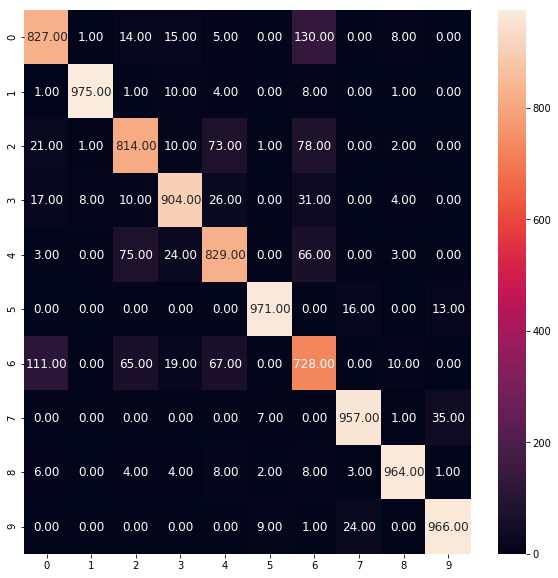

In [35]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, annot_kws={'size': 12}, fmt='.2f')